In [1]:
!pip uninstall shapely -y
!pip install shapely
!pip install contextily

Found existing installation: Shapely 1.6.4.post2
Uninstalling Shapely-1.6.4.post2:
  Successfully uninstalled Shapely-1.6.4.post2
     |████████████████████████████████| 1.0 MB 20.4 MB/s eta 0:00:01
ERROR: imgaug 0.4.0 requires opencv-python, which is not installed.


In [2]:
import torch
import numpy as np

import model, model_utils, preprocessing_utils, analysis

In [3]:
num_timesteps_input = 8 # 40 minutes
num_timesteps_output = 4 # 20 minutes
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "./saved_models/Final_STGCN_Weights"

In [4]:
loaded_model, loaded_optimizer = model_utils.load_model()

Loading model in path : ./saved_models/20210627/18_50_30


In [5]:
raw_trunc_dir = "./data/raw/trunc/"
process_dir = "./data/processed/"

preprocessing_utils.processed(raw_trunc_dir, process_dir, overwrite=False)
A, X, metadata, cat2index, timestamps, means, stds = preprocessing_utils.load(process_dir)

split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.8)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

training_input, training_target = preprocessing_utils.generate_dataset(train_original_data,
                                                   num_timesteps_input=num_timesteps_input,
                                                   num_timesteps_output=num_timesteps_output)
val_input, val_target = preprocessing_utils.generate_dataset(val_original_data,
                                         num_timesteps_input=num_timesteps_input,
                                         num_timesteps_output=num_timesteps_output)
test_input, test_target = preprocessing_utils.generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)

adj_mat = preprocessing_utils.get_normalized_adj(A)
adj_mat = torch.from_numpy(adj_mat).float()

In [6]:
loaded_model.to(device)
adj_mat = adj_mat.to(device)
test_input = test_input.to(device)

with torch.no_grad():
    predicted = model_utils.predict(loaded_model, test_input, adj_mat)

# Geographical Analysis

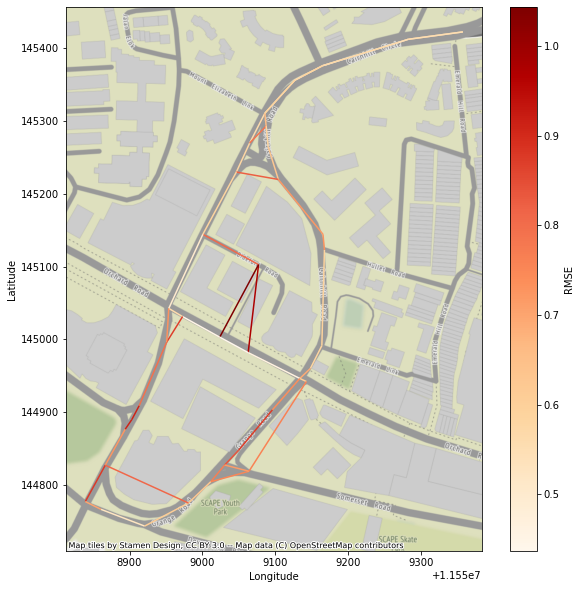

In [7]:
predicted_denorm = preprocessing_utils.denormalize(predicted.to("cpu"), stds[0], means[0])
actual_denorm = preprocessing_utils.denormalize(test_target, stds[0], means[0])

rmses = analysis.rmse_per_link(predicted_denorm, actual_denorm)
analysis.plot_geo_performance(metadata, rmses)

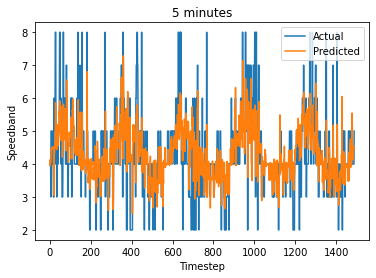

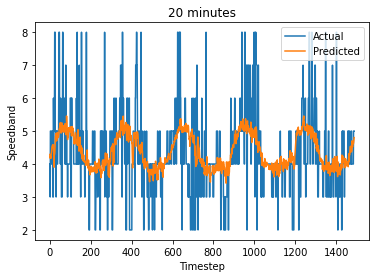

In [8]:
worst_road = np.argmax(rmses)
analysis.plot_pred_actual(predicted_denorm, actual_denorm, worst_road, 0)
analysis.plot_pred_actual(predicted_denorm, actual_denorm, worst_road, 3)

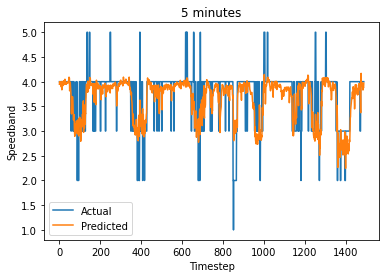

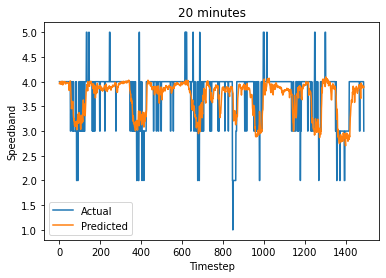

In [9]:
best_road = np.argmin(rmses)
analysis.plot_pred_actual(predicted_denorm, actual_denorm, best_road, 0)
analysis.plot_pred_actual(predicted_denorm, actual_denorm, best_road, 3)

# Temporal Analysis

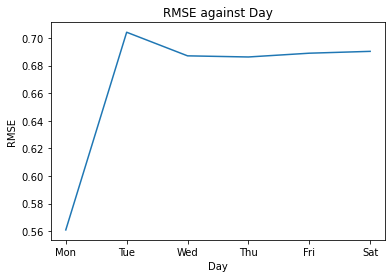

{'Mon': 202, 'Tue': 1152, 'Wed': 1152, 'Thu': 1152, 'Fri': 1152, 'Sat': 1146}

In [10]:
rmses, rmse_counts = analysis.rmse_per_time(predicted_denorm, actual_denorm, timestamps, timeidx = 0)
analysis.plot_rmse_time(rmses, "Day")
rmse_counts

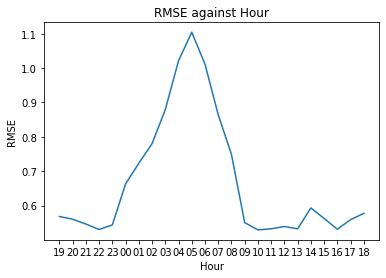

{'19': 250,
 '20': 288,
 '21': 288,
 '22': 288,
 '23': 282,
 '00': 240,
 '01': 240,
 '02': 240,
 '03': 240,
 '04': 240,
 '05': 240,
 '06': 240,
 '07': 240,
 '08': 240,
 '09': 240,
 '10': 240,
 '11': 240,
 '12': 240,
 '13': 240,
 '14': 240,
 '15': 240,
 '16': 240,
 '17': 240,
 '18': 240}

In [11]:
rmses, rmse_counts = analysis.rmse_per_time(predicted_denorm, actual_denorm, timestamps, timeidx = 4)
analysis.plot_rmse_time(rmses, "Hour")
rmse_counts